In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

from tqdm.notebook import tqdm_notebook as tqdm
import cv2

In [0]:
CLASS = {
    'with_mask': 0,
    'without_mask': 1
}

In [0]:
def preprop_img(image_path, verbose=0):
    if verbose:
        print(image_path)
    img=cv2.imread(image_path)
    img=cv2.resize(img, (128,128))
    return img

In [4]:
X=[]
Y=[]
BASE='/content/drive/My Drive/Colab Notebooks/Mask detector/face-mask-detector/dataset'
for i in tqdm(os.listdir(BASE), total=len(CLASS)):
    for j in tqdm(os.listdir(os.path.join(BASE,i))):
        X.append(preprop_img(os.path.join(BASE,i,j)))
        Y.append(CLASS[i])

In [44]:
data=np.array(X)
labels=np.array(Y)
print(data.shape, labels.shape)

(1376, 128, 128, 3) (1376,)


In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [48]:
trainX.shape

(1100, 128, 128, 3)

In [49]:
testX.shape

(276, 128, 128, 3)

In [0]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [51]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)))

In [0]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2,2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [0]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [55]:
# compile our model

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [56]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=20)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 23s 671ms/step - loss: 0.6338 - accuracy: 0.7298 - val_loss: 0.2873 - val_accuracy: 0.9058
Epoch 2/20
34/34 [==============================] - 18s 535ms/step - loss: 0.3278 - accuracy: 0.8530 - val_loss: 0.2319 - val_accuracy: 0.9275
Epoch 3/20
34/34 [==============================] - 18s 531ms/step - loss: 0.2690 - accuracy: 0.8801 - val_loss: 0.2178 - val_accuracy: 0.9275
Epoch 4/20
34/34 [==============================] - 18s 529ms/step - loss: 0.2622 - accuracy: 0.8942 - val_loss: 0.1951 - val_accuracy: 0.9203
Epoch 5/20
34/34 [==============================] - 18s 529ms/step - loss: 0.2311 - accuracy: 0.9017 - val_loss: 0.1886 - val_accuracy: 0.9203
Epoch 6/20
34/34 [==============================] - 18s 528ms/step - loss: 0.1757 - accuracy: 0.9232 - val_loss: 0.1861 - val_accuracy: 0.9312
Epoch 7/20
34/34 [==============================] - 18s 531ms/step - loss: 0.1883 - accuracy: 0.9223 - val_loss: 0.167

In [72]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [0]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [60]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       138
           1       0.93      0.97      0.95       138

    accuracy                           0.95       276
   macro avg       0.95      0.95      0.95       276
weighted avg       0.95      0.95      0.95       276



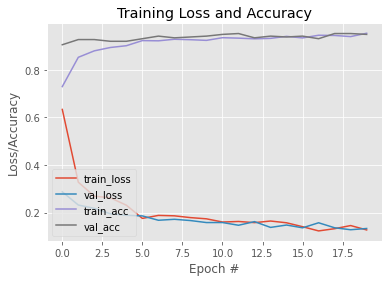

In [63]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

0


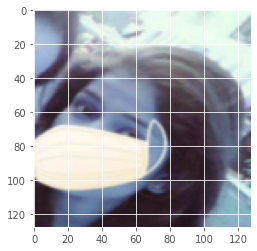

For 0th image:
	The actual label class:  0
	The predicted label class:  0
1


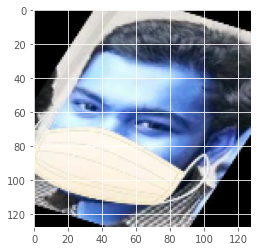

For 1th image:
	The actual label class:  0
	The predicted label class:  0
2


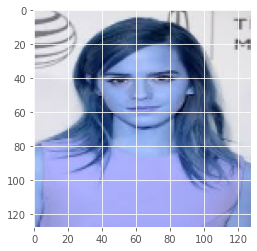

For 2th image:
	The actual label class:  1
	The predicted label class:  1
3


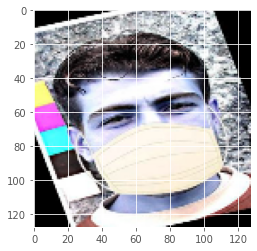

For 3th image:
	The actual label class:  0
	The predicted label class:  0
4


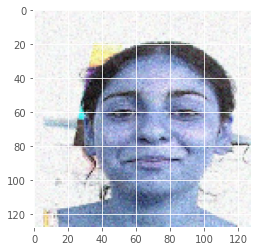

For 4th image:
	The actual label class:  1
	The predicted label class:  1


In [81]:
count = 0
for i in range(0,np.random.randint(0,testX.shape[0])):
  print(i)
  plt.imshow(testX[i],cmap='gray')
  plt.show()
  print("For {}th image:".format(i))
  print("\tThe actual label class: ",np.argmax(testY[i]))
  print("\tThe predicted label class: ",predIdxs[i])
  count+=1
  if count == 5:
    break
  else:
    continue